# 데이터 로드

In [1]:
import pandas as pd
df = pd.read_csv('data.csv', encoding='cp949', low_memory=False)
df = df.dropna()
df['주문번호'] = df['주문번호'].astype(str)
df['고객번호'] = df['고객번호'].astype(str)
df['배송완료일'] = pd.to_datetime(df['배송완료일'], format='%Y-%m-%d', errors='coerce')
df['배송시작일'] = pd.to_datetime(df['배송시작일'], format='%Y-%m-%d', errors='coerce')
df['구매일'] = pd.to_datetime(df['구매일'], format='%Y-%m-%d', errors='coerce')
df = df[df['결제금액'] >= 0].reset_index(drop=True)
df['물품대분류'] = df['물품대분류'].astype('category')
df['성별'] = df['성별'].astype('category')
df['결혼유무'] = df['결혼유무'].astype('category')
df['유입경로'] = df['유입경로'].astype('category')
df['자녀여부'] = df['자녀여부'].astype('category')
df['남아여아공용'] = df['남아여아공용'].astype('category')
df['원플원'] = df['원플원'].astype('category')
df['핫딜'] = df['핫딜'].astype('category')
df['기저귀단계'] = df['기저귀단계'].astype('category')
df['아이정보건너뛰기'] = df['아이정보건너뛰기'].astype('category')
df['구매시월령_bin'] = df['구매시월령_bin'].astype('category')
df['거주지역'] = df['거주지역'].astype('category')
df['결제등록카드'] = df['결제등록카드'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185350 entries, 0 to 185349
Data columns (total 27 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   주문번호       185350 non-null  object        
 1   배송완료일      185350 non-null  datetime64[ns]
 2   배송시작일      185350 non-null  datetime64[ns]
 3   구매일        185350 non-null  datetime64[ns]
 4   구매시월령      185350 non-null  float64       
 5   고객번호       185350 non-null  object        
 6   구매금액       185350 non-null  int64         
 7   결제금액       185350 non-null  int64         
 8   물품대분류      185350 non-null  category      
 9   상품명        185350 non-null  object        
 10  물품판매량      185350 non-null  int64         
 11  제품단가       185350 non-null  int64         
 12  성별         185350 non-null  category      
 13  결혼유무       185350 non-null  category      
 14  거주지역       185350 non-null  category      
 15  연령         185350 non-null  float64       
 16  결제등록카드     185350 no

# 이탈 고객 정의

In [52]:
df['구매일'].sort_values()

0        2022-01-01
27       2022-01-01
28       2022-01-01
29       2022-01-01
30       2022-01-01
            ...    
185279   2023-08-08
185278   2023-08-08
185277   2023-08-08
185275   2023-08-08
185349   2023-08-08
Name: 구매일, Length: 185350, dtype: datetime64[ns]

In [2]:
# 1. 고객별 구매 정보 집계
customer_df = df.groupby('고객번호').agg({'구매일': ['min', 'max', 'count'],'구매금액': 'sum'}).reset_index()
customer_df.columns = ['고객번호', '최초구매일', '최종구매일', '구매횟수', '총구매금액']

✅ 1. 최종구매일 분포 확인

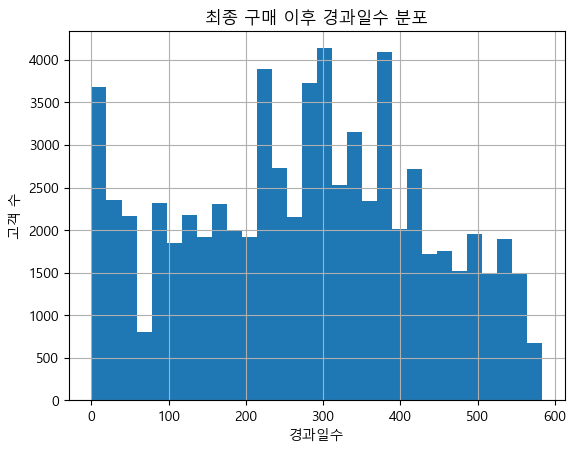

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 구매 기준일 마지막 날짜
last_date = df['구매일'].max()

# 고객별 최종구매일로부터 며칠 지났는지 계산
customer_df['경과일수'] = (last_date - customer_df['최종구매일']).dt.days

# 분포 시각화
plt.hist(customer_df['경과일수'], bins=30)
plt.title('최종 구매 이후 경과일수 분포')
plt.xlabel('경과일수')
plt.ylabel('고객 수')
plt.grid(True)
plt.show()


✅ 2. 이탈률 변화 시뮬레이션

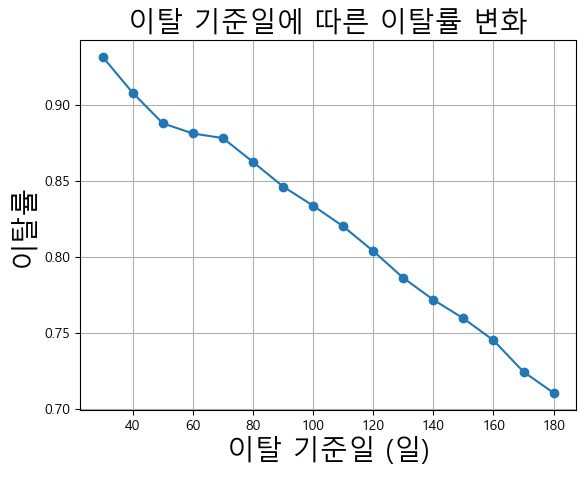

In [4]:
import numpy as np

candidate_days = range(30, 181, 10)  # 30~180일 사이 10일 간격
ratios = []

for d in candidate_days:
    ratio = (customer_df['경과일수'] > d).mean()
    ratios.append(ratio)

# 시각화
plt.plot(candidate_days, ratios, marker='o')
plt.title('이탈 기준일에 따른 이탈률 변화', fontsize=20)
plt.xlabel('이탈 기준일 (일)', fontsize=20)
plt.ylabel('이탈률', fontsize=20)
plt.grid(True)
plt.show()


✅ 3. 추천 기준일 설정 전략

| 기준일         | 이탈률   | 비고                                     |
| ----------- | ----- | -------------------------------------- |
| **60일**     | 약 89% | 너무 보수적 → 이탈로 간주되는 고객 수 많음 (불필요한 관리 부담) |
| **90일**     | 약 86% | 적절한 수준의 이탈률, 보편적으로 많이 사용               |
| **120일**    | 약 82% | 중립적인 기준, noise 감소 기대 가능                |
| **150일 이상** | ≤75%  | 이탈 고객 정의가 너무 느슨해져 민감도 하락 우려            |


✅ 목표: 이탈률이 85%에 가장 가까운 기준일 선택

In [5]:
import pandas as pd
import numpy as np

# ✅ 1. 고객별 구매 이력 집계
customer_df = df.groupby('고객번호').agg({
    '구매일': ['min', 'max', 'count'],
    '구매금액': 'sum'
}).reset_index()

customer_df.columns = ['고객번호', '최초구매일', '최종구매일', '구매횟수', '총구매금액']

# ✅ 2. 고객별 최종구매일로부터 경과일수 계산
기준일 = df['구매일'].max()
customer_df['최종구매_경과일'] = (기준일 - customer_df['최종구매일']).dt.days

# ✅ 3. 자동 이탈 기준일 탐색
이탈률_목표 = 0.85
threshold_candidates = np.arange(30, 181, 5)

result = []
for d in threshold_candidates:
    이탈률 = (customer_df['최종구매_경과일'] > d).mean()
    result.append({'기준일': d, '이탈률': 이탈률, '차이': abs(이탈률 - 이탈률_목표)})

result_df = pd.DataFrame(result)
best_threshold = result_df.loc[result_df['차이'].idxmin(), '기준일']

print(f"🎯 자동으로 선택된 이탈 기준일: {best_threshold}일 (목표 이탈률 ≈ {이탈률_목표 * 100:.1f}%)")

# ✅ 4. 이탈 여부 생성 (자동 기준일 기준)
customer_df['이탈여부'] = (customer_df['최종구매_경과일'] > best_threshold).astype(int)

# ✅ 5. 고객별 고정 속성 병합
customer_info = df[['고객번호', '성별', '연령', '거주지역', '결혼유무', '자녀여부']].drop_duplicates(subset='고객번호')
customer_df = customer_df.merge(customer_info, on='고객번호', how='left')

# ✅ 6. 최종 이탈률 확인
print(customer_df['이탈여부'].value_counts(normalize=True).rename('비율'))


🎯 자동으로 선택된 이탈 기준일: 85일 (목표 이탈률 ≈ 85.0%)
1    0.853293
0    0.146707
Name: 비율, dtype: float64


# 모델

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 💡 기준일 설정
기준일 = pd.to_datetime("2023-01-01")

# ✅ 기준일까지의 이력만 사용
df_cut = df[df['구매일'] <= 기준일].copy()
df_cut = df_cut.sort_values(['고객번호', '구매일'])

# ✅ 1) 구매 간격 - 최근 3회 평균
df_cut['이전구매일'] = df_cut.groupby('고객번호')['구매일'].shift(1)
df_cut['구매간격'] = (df_cut['구매일'] - df_cut['이전구매일']).dt.days

recent_interval = (
    df_cut.groupby('고객번호')['구매간격']
    .apply(lambda x: x.tail(3).mean())
    .to_frame(name='최근3회평균구매간격')
)

# ✅ 2) 구매금액 관련
amount_agg = df_cut.groupby('고객번호')['구매금액'].agg(['mean', 'std', 'max', 'min'])
amount_agg.columns = ['평균구매금액', '구매금액_std', '최대구매금액', '최소구매금액']
amount_agg['평균장바구니금액'] = (
    df_cut.groupby('고객번호')['구매금액'].sum() /
    df_cut.groupby('고객번호')['구매일'].count()
)

# ✅ 3) 다양성
diversity_agg = df_cut.groupby('고객번호').agg({
    '물품대분류': lambda x: x.nunique(),
    '브랜드': lambda x: x.nunique()
}).rename(columns={
    '물품대분류': '물품대분류_종류수',
    '브랜드': '브랜드_종류수'
})

# ✅ 4) 프로모션 반응성
promo_agg = (
    df_cut[['고객번호', '핫딜', '원플원']]
    .assign(
        핫딜_num=df_cut['핫딜'].cat.codes,
        원플원_num=df_cut['원플원'].cat.codes
    )
    .groupby('고객번호')
    .agg({
        '핫딜_num': 'mean',
        '원플원_num': 'mean'
    })
    .rename(columns={
        '핫딜_num': '핫딜구매비율',
        '원플원_num': '원플원구매비율'
    })
)

# ✅ 고정 고객 속성
cust_static = df_cut[['고객번호', '성별', '연령', '거주지역', '결혼유무', '자녀여부']].drop_duplicates('고객번호')

# ✅ 이탈 레이블
cust_label = customer_df[['고객번호', '이탈여부', '최초구매일', '최종구매일', '최종구매_경과일']]

# ✅ 병합
base_df = cust_label.merge(cust_static, on='고객번호', how='left')
for feat in [recent_interval, amount_agg, diversity_agg, promo_agg]:
    base_df = base_df.merge(feat, left_on='고객번호', right_index=True, how='left')

# ✅ 결측값 처리
num_cols = base_df.select_dtypes(include=np.number).columns
for col in num_cols:
    base_df[col] = base_df[col].fillna(base_df[col].median())

cat_cols = base_df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    base_df[col] = base_df[col].fillna(base_df[col].mode().iloc[0])

# ✅ X, y 정의
drop_cols = ['고객번호', '최초구매일', '최종구매일', '이탈여부', '최종구매_경과일']
X = base_df.drop(columns=drop_cols)
y = base_df['이탈여부']

# ✅ 범주형 인코딩
cat_feats = X.select_dtypes(include=['object', 'category']).columns
for col in cat_feats:
    X[col] = LabelEncoder().fit_transform(X[col])

# ✅ 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


AutoML

In [45]:
from pycaret.classification import setup, compare_models, pull

# 1️⃣ PyCaret용 DataFrame 준비
df_py = X.copy()
df_py['target'] = y.values

# 2️⃣ setup 실행 (불필요한 인자 제거)
clf1 = setup(
    data=df_py,
    target='target',
    session_id=42,
    fix_imbalance=True,
    train_size=0.8,
    fold=10,
    verbose=False  # 로그 출력 최소화
)

# 3️⃣ Setup 요약 정보 출력
setup_summary = pull()
print("\n▶️ Setup Summary:")
print(setup_summary.to_string(index=False))

# 4️⃣ 모델 비교 (AUC 기준)
best_models = compare_models(sort='AUC', fold=10)

# 5️⃣ 모델 비교 결과 출력
compare_results = pull()
print("\n▶️ Model Comparison:")
print(compare_results.to_string(index=False))



▶️ Setup Summary:
                Description            Value
                 Session id               42
                     Target           target
                Target type           Binary
        Original data shape      (69458, 16)
     Transformed data shape     (108720, 16)
Transformed train set shape      (94828, 16)
 Transformed test set shape      (13892, 16)
           Numeric features               15
                 Preprocess             True
            Imputation type           simple
         Numeric imputation             mean
     Categorical imputation             mode
              Fix imbalance             True
       Fix imbalance method            SMOTE
             Fold Generator  StratifiedKFold
                Fold Number               10
                   CPU Jobs               -1
                    Use GPU            False
             Log Experiment            False
            Experiment Name clf-default-name
                        USI         

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8217,0.7529,0.8970,0.8944,0.8957,0.2829,0.2829,0.4170
xgboost,Extreme Gradient Boosting,0.8187,0.7426,0.8919,0.8952,0.8936,0.2821,0.2821,0.2660
gbc,Gradient Boosting Classifier,0.8105,0.7380,0.8767,0.8988,0.8876,0.2854,0.2863,3.1000
rf,Random Forest Classifier,0.7972,0.7378,0.8574,0.9001,0.8783,0.2728,0.2757,2.2980
ada,Ada Boost Classifier,0.7648,0.7314,0.7985,0.9150,0.8528,0.2810,0.2979,0.7680
et,Extra Trees Classifier,0.7913,0.7311,0.8492,0.9006,0.8741,0.2673,0.2713,1.6550
lda,Linear Discriminant Analysis,0.6634,0.7185,0.6493,0.9369,0.7670,0.2270,0.2842,0.1230
knn,K Neighbors Classifier,0.7228,0.7017,0.7477,0.9123,0.8212,0.2238,0.2499,0.8490
lr,Logistic Regression,0.6414,0.6990,0.6348,0.9222,0.7507,0.1764,0.2257,0.8180
nb,Naive Bayes,0.7559,0.6844,0.8288,0.8789,0.8525,0.1375,0.1416,0.0940



▶️ Model Comparison:
                          Model  Accuracy    AUC  Recall  Prec.     F1  Kappa    MCC  TT (Sec)
Light Gradient Boosting Machine    0.8217 0.7529  0.8970 0.8944 0.8957 0.2829 0.2829     0.417
      Extreme Gradient Boosting    0.8187 0.7426  0.8919 0.8952 0.8936 0.2821 0.2821     0.266
   Gradient Boosting Classifier    0.8105 0.7380  0.8767 0.8988 0.8876 0.2854 0.2863     3.100
       Random Forest Classifier    0.7972 0.7378  0.8574 0.9001 0.8783 0.2728 0.2757     2.298
           Ada Boost Classifier    0.7648 0.7314  0.7985 0.9150 0.8528 0.2810 0.2979     0.768
         Extra Trees Classifier    0.7913 0.7311  0.8492 0.9006 0.8741 0.2673 0.2713     1.655
   Linear Discriminant Analysis    0.6634 0.7185  0.6493 0.9369 0.7670 0.2270 0.2842     0.123
         K Neighbors Classifier    0.7228 0.7017  0.7477 0.9123 0.8212 0.2238 0.2499     0.849
            Logistic Regression    0.6414 0.6990  0.6348 0.9222 0.7507 0.1764 0.2257     0.818
                    Naive Ba

튜닝 및 해석 진행

In [9]:
from pycaret.classification import tune_model

# 1) 베스트 모델 튜닝 (AUC 기준 10-fold)
tuned = tune_model(
    best_models[0] if isinstance(best_models, list) else best_models,
    optimize='AUC',
    fold=10
)

# 2) CV 결과 가져오기
cv_results = pull()

# 3) 인덱스를 Fold 0–9, Mean, Std 로 지정
fold_labels = list(range(10)) + ['Mean', 'Std']
cv_results.index = fold_labels

# 4) 원하는 컬럼만 선택 (원본 DataFrame 열 확인 후 그대로 사용)
cols = ['Accuracy','AUC','Recall','Prec.','F1','Kappa','MCC']
cv_results = cv_results[cols]

# 5) 출력
print("\n▶️ CV Results:")
print(cv_results.to_string())


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9204,0.9435,0.9677,0.9407,0.9540,0.6584,0.6620
1,0.9087,0.9383,0.9631,0.9321,0.9474,0.6033,0.6080
2,0.9091,0.9301,0.9677,0.9288,0.9478,0.5959,0.6036
3,0.9163,0.9395,0.9694,0.9349,0.9518,0.6329,0.6390
4,0.9060,0.9327,0.9612,0.9309,0.9458,0.5925,0.5968
5,0.9074,0.9362,0.9569,0.9361,0.9464,0.6093,0.6113
6,0.9097,0.9361,0.9641,0.9324,0.9480,0.6071,0.6120
7,0.9099,0.9312,0.9634,0.9332,0.9480,0.6102,0.6146
8,0.9099,0.9301,0.9609,0.9352,0.9479,0.6150,0.6181


Fitting 10 folds for each of 10 candidates, totalling 100 fits

▶️ CV Results:
      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9204  0.9435  0.9677  0.9407  0.9540  0.6584  0.6620
1       0.9087  0.9383  0.9631  0.9321  0.9474  0.6033  0.6080
2       0.9091  0.9301  0.9677  0.9288  0.9478  0.5959  0.6036
3       0.9163  0.9395  0.9694  0.9349  0.9518  0.6329  0.6390
4       0.9060  0.9327  0.9612  0.9309  0.9458  0.5925  0.5968
5       0.9074  0.9362  0.9569  0.9361  0.9464  0.6093  0.6113
6       0.9097  0.9361  0.9641  0.9324  0.9480  0.6071  0.6120
7       0.9099  0.9312  0.9634  0.9332  0.9480  0.6102  0.6146
8       0.9099  0.9301  0.9609  0.9352  0.9479  0.6150  0.6181
9       0.9109  0.9354  0.9696  0.9291  0.9489  0.6029  0.6114
Mean    0.9108  0.9353  0.9644  0.9333  0.9486  0.6128  0.6177
Std     0.0041  0.0042  0.0039  0.0034  0.0024  0.0185  0.0181


최종 모델 저장 및 예측

In [11]:
from pycaret.classification import finalize_model, predict_model

final_model = finalize_model(best_models)
preds = predict_model(final_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9156,0.9429,0.9624,0.9401,0.9511,0.6423,0.6447


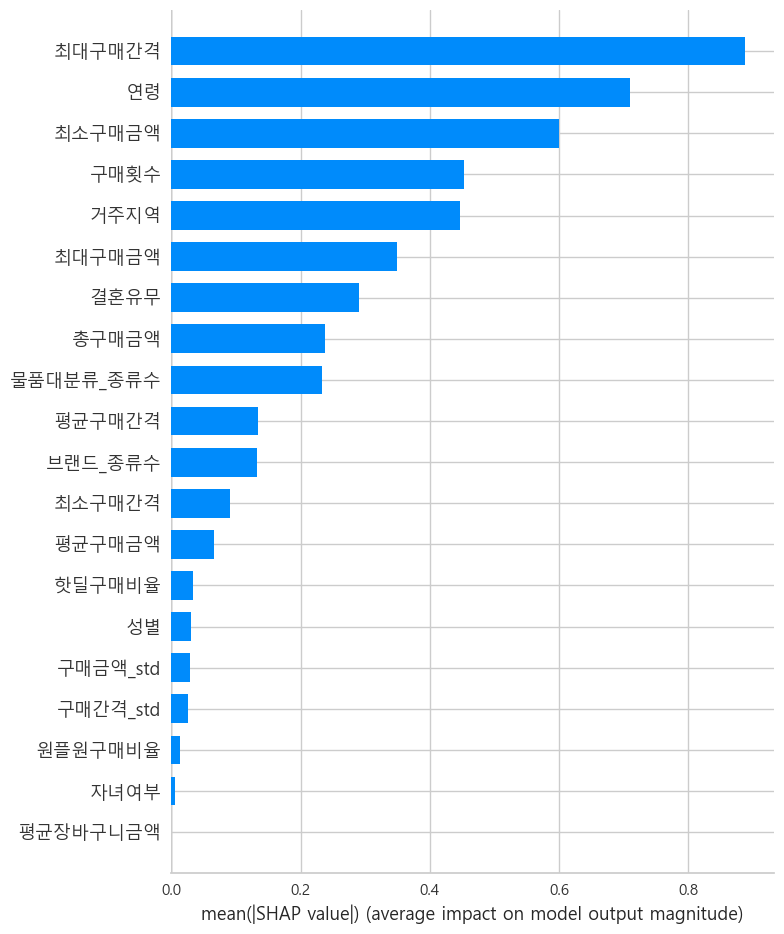

In [37]:
import matplotlib.pyplot as plt
import matplotlib

# 1. 폰트 설정 (Windows: 맑은 고딕)
matplotlib.rc('font', family='Malgun Gothic')

# 2. 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


import shap

# 1. PyCaret 내부 모델 추출
model_native = final_model.named_steps['actual_estimator']

# 2. 원래 X_test 사용 — 이건 setup 이전에 인코딩까지 끝났던 버전
X_shap = X_test.copy()

# 3. SHAP explainer 생성 및 SHAP 값 계산
explainer = shap.TreeExplainer(model_native)
shap_values = explainer.shap_values(X_shap)

# 4. 이진 분류라면 클래스 1 선택
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 5. 시각화
shap.summary_plot(shap_values, X_shap, plot_type='bar')

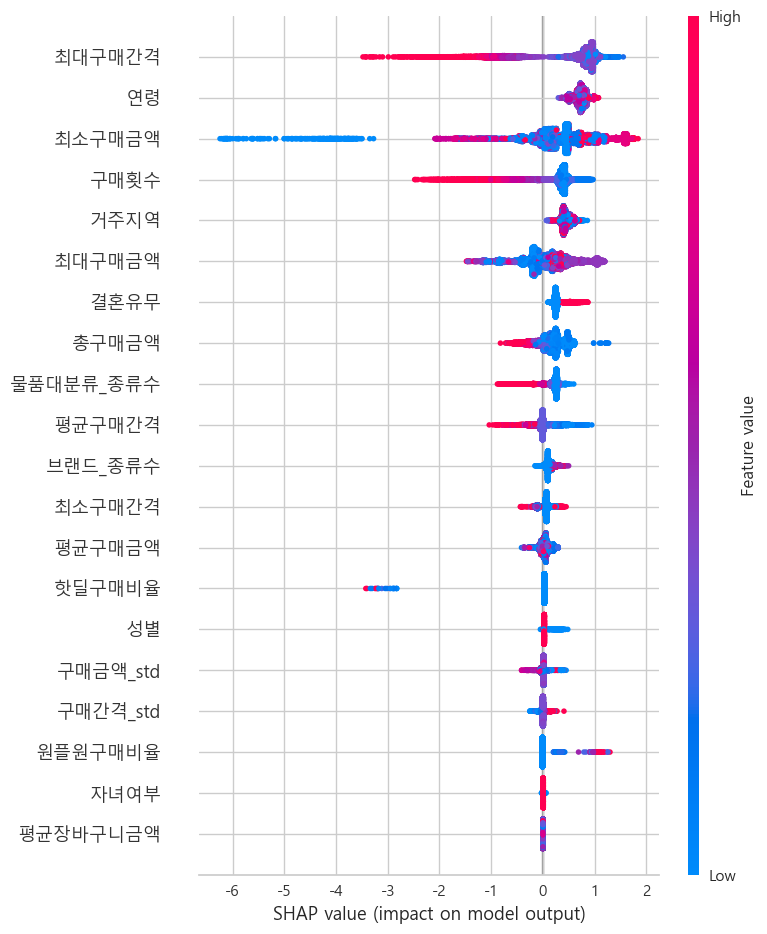

In [38]:
shap.summary_plot(shap_values, X_shap)